In [52]:
import pandas as pd
from urllib.parse import urlparse,parse_qs
import math
from collections import Counter
import string
import tldextract
from collections import Counter
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import ipaddress


In [53]:
url_df = pd.read_csv('url_dataset.csv')

# Print the number of lines in the final CSV
print(f"Total number of URLs: {len(url_df)}")

# Print the number of samples for each class
print("Number of samples per class:")
print(url_df['label'].value_counts())



Total number of URLs: 972019
Number of samples per class:
label
benign      773818
phishing    140608
malware      54470
spam          3123
Name: count, dtype: int64


In [54]:
url_df_features = pd.read_csv('smaller_url_dataset_features.csv')

# Print the number of lines in the final CSV
print(f"Total number of URLs: {len(url_df_features)}")

# Print the number of samples for each class
print("Number of samples per class:")
print(url_df_features['label'].value_counts())


Total number of URLs: 107114
Number of samples per class:
label
benign      57821
malware     31850
phishing    14320
spam         3123
Name: count, dtype: int64


In [55]:
# Filter rows where 'domain' is 'no_domain'
no_domain_rows = url_df_features[url_df_features['domain'] == 'no_domain']

# Check if all these filtered rows have 'contains_ip' set to 1
all_have_ip = no_domain_rows['contains_ip'].all()

print("All 'no_domain' rows contain IP:", all_have_ip)


All 'no_domain' rows contain IP: True


In [56]:
# Filter rows where 'domain' is 'no_domain' but 'contains_ip' is not set to 1
mismatch_rows = url_df_features[(url_df_features['domain'] == 'no_domain') & (url_df_features['contains_ip'] != 1)]

# Display the rows to see the discrepancy
print("Rows with 'no_domain' but without 'contains_ip' set to 1:")
print(mismatch_rows)


# Print the number of such rows
print("\nNumber of rows with 'no_domain' but without 'contains_ip' set to 1:", len(mismatch_rows))

Rows with 'no_domain' but without 'contains_ip' set to 1:
Empty DataFrame
Columns: [url, label, domain, path_url, query_url, url_length, domain_length, url_kl_divergence, domain_kl_divergence, path_kl_divergence, query_kl_divergence, query_path_kl_divergence, num_special_symbols, contains_ip, tokens, presence_of_suspicious_file_extensions, sub_domains_count, digit_frequency, count_tlds, is_short_url]
Index: []

Number of rows with 'no_domain' but without 'contains_ip' set to 1: 0


In [57]:
print(url_df_features.isnull().sum())


url                                       0
label                                     0
domain                                    0
path_url                                  0
query_url                                 0
url_length                                0
domain_length                             0
url_kl_divergence                         0
domain_kl_divergence                      0
path_kl_divergence                        0
query_kl_divergence                       0
query_path_kl_divergence                  0
num_special_symbols                       0
contains_ip                               0
tokens                                    0
presence_of_suspicious_file_extensions    0
sub_domains_count                         0
digit_frequency                           0
count_tlds                                0
is_short_url                              0
dtype: int64


In [58]:
features = ['url_length', 'domain_length', 'url_kl_divergence','num_special_symbols', 'contains_ip',
                         'domain_kl_divergence','path_kl_divergence','query_kl_divergence', 'query_path_kl_divergence', 
                         'presence_of_suspicious_file_extensions','sub_domains_count',
                         'digit_frequency', 
                         'count_tlds','is_short_url']

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def plot_cdf_for_classes(df, features, labels_column):
    sns.set(style="whitegrid")
    class_labels = df[labels_column].unique()

    # Define a color palette
    palette = sns.color_palette("hsv", len(class_labels))

    for feature in features:
        # Split the dataset into training and validation sets
        train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

        plt.figure(figsize=(14, 6))

        # Plot CDF for Training Data
        plt.subplot(1, 2, 1)
        for idx, label in enumerate(class_labels):
            data_train = np.sort(train_df[train_df[labels_column] == label][feature])
            plt.plot(data_train, np.linspace(0, 1, len(data_train), endpoint=False), label=f'{label} - Train', color=palette[idx])
        plt.title(f'Training Set CDF - {feature}')
        plt.xlabel(feature)
        plt.ylabel('CDF')
        plt.legend()


        plt.tight_layout()
        plt.show()


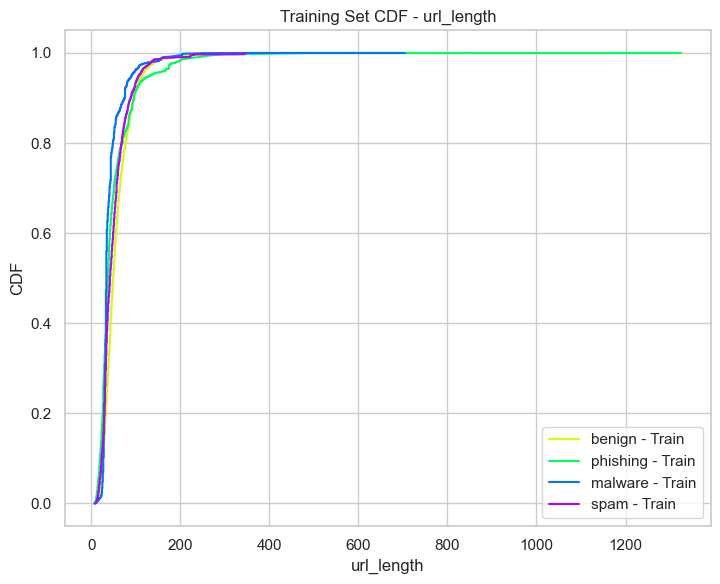

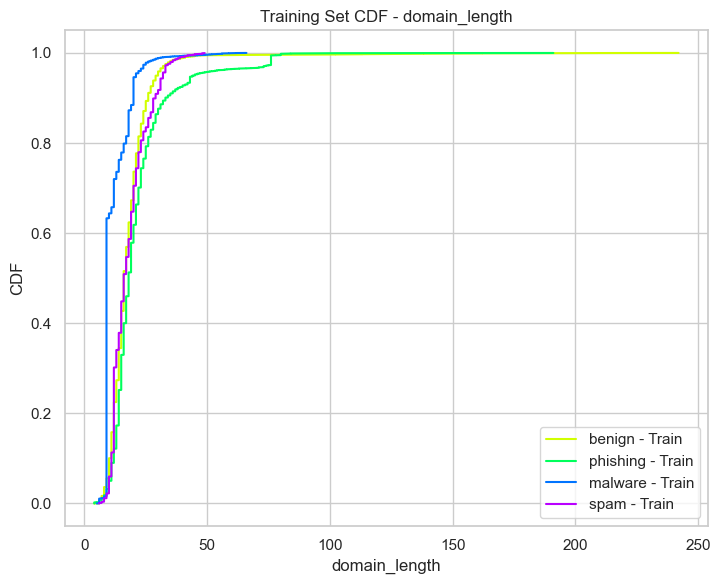

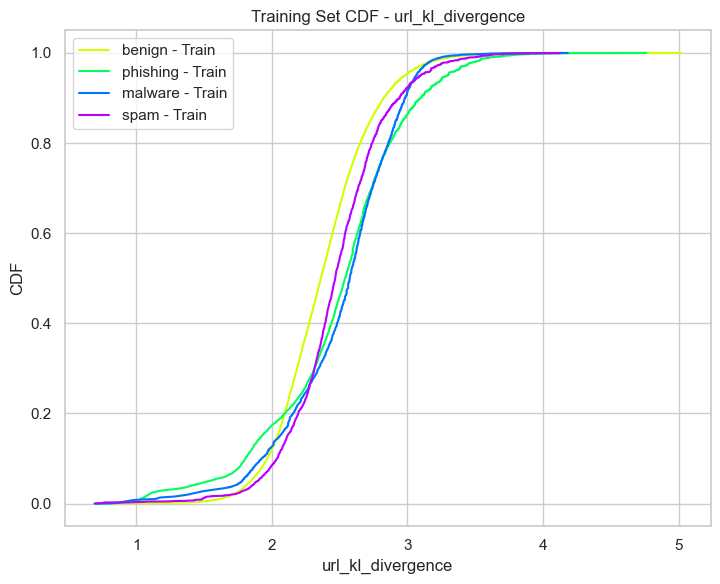

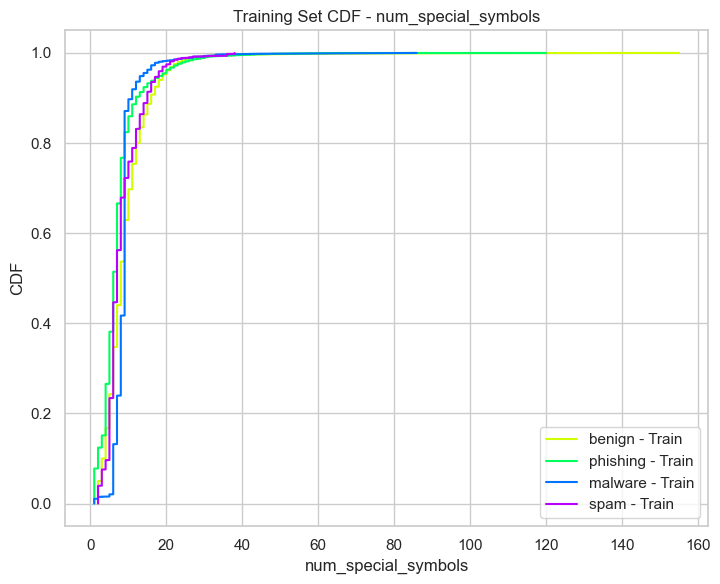

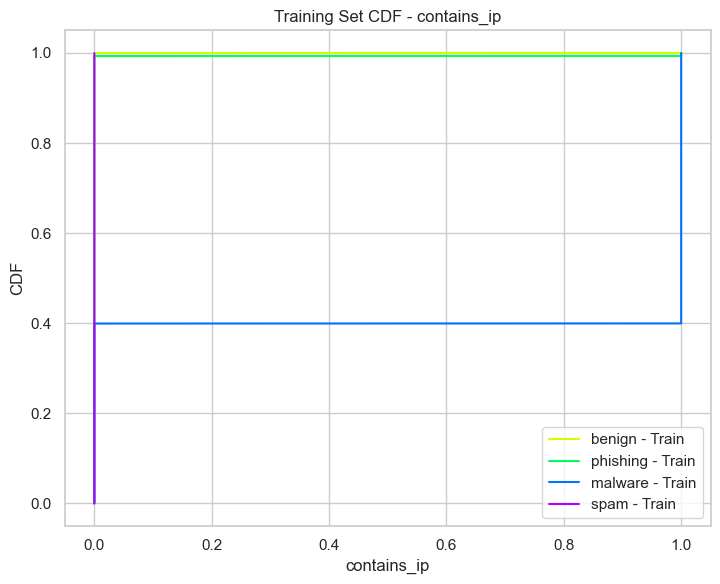

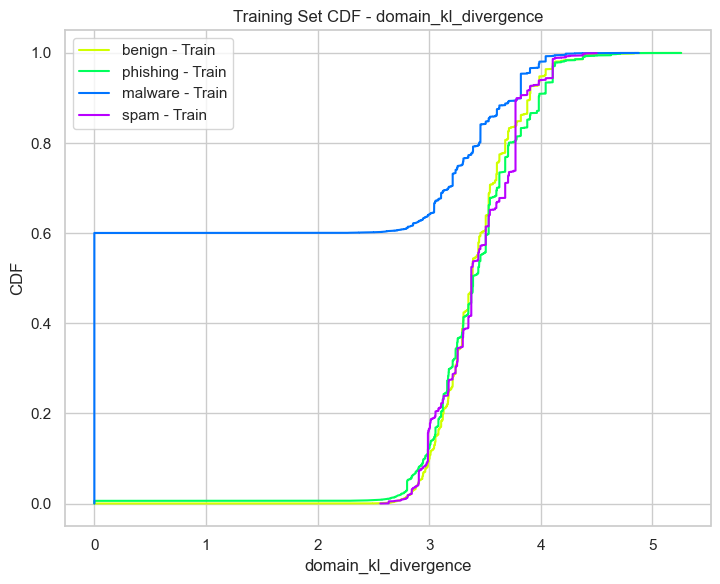

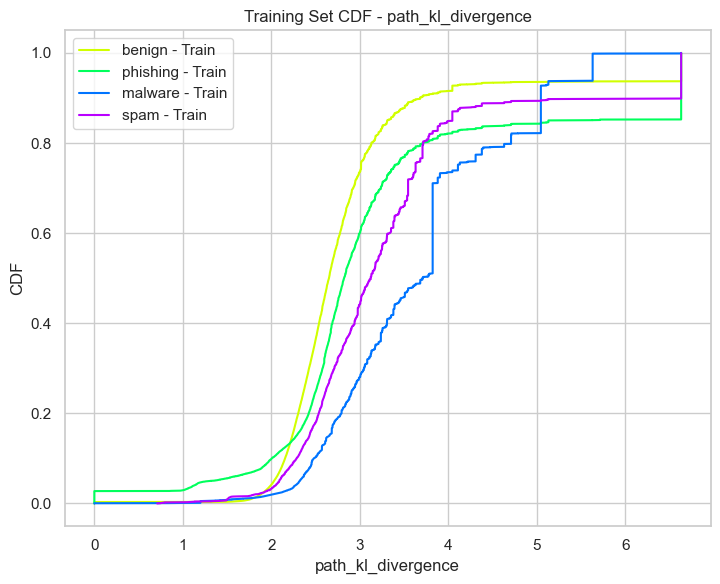

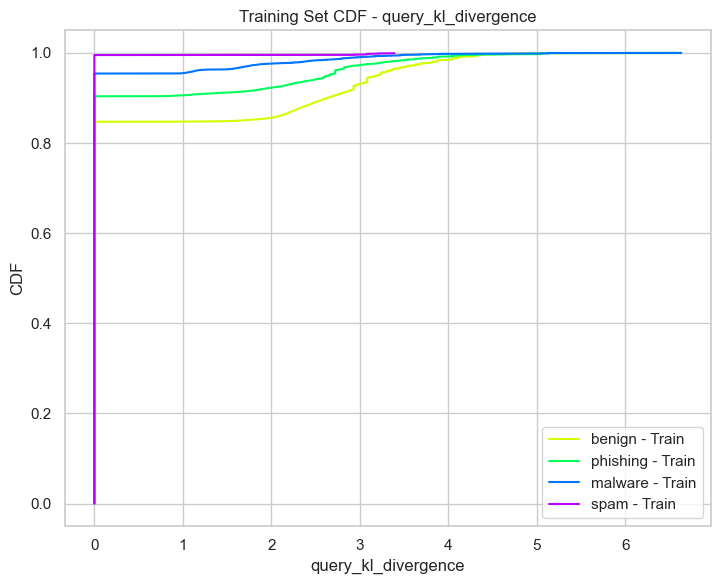

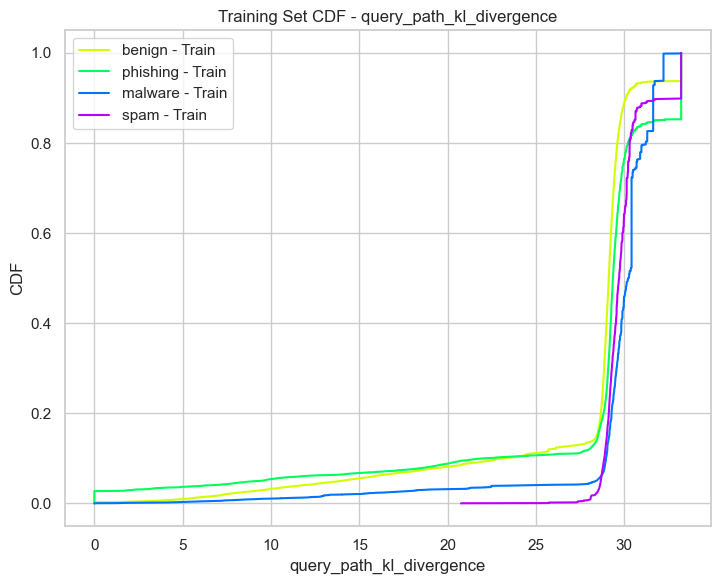

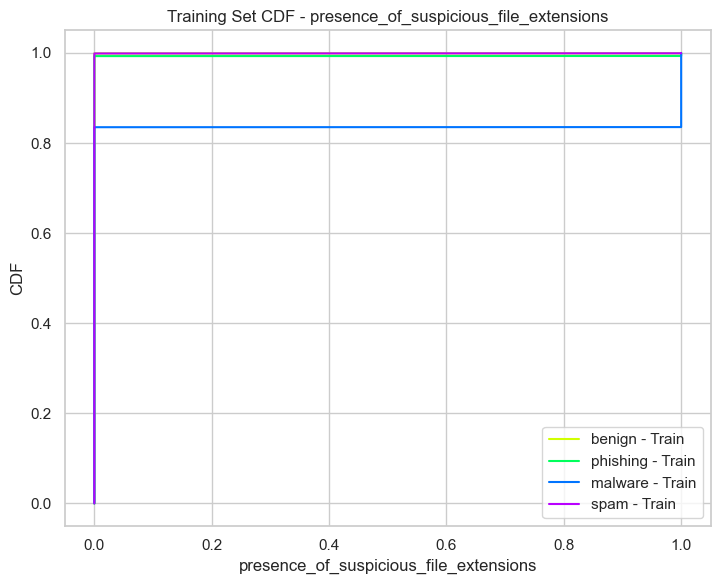

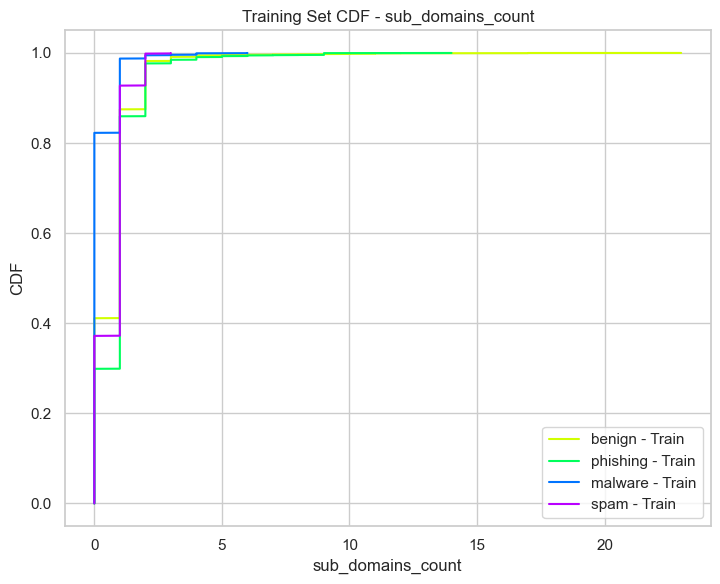

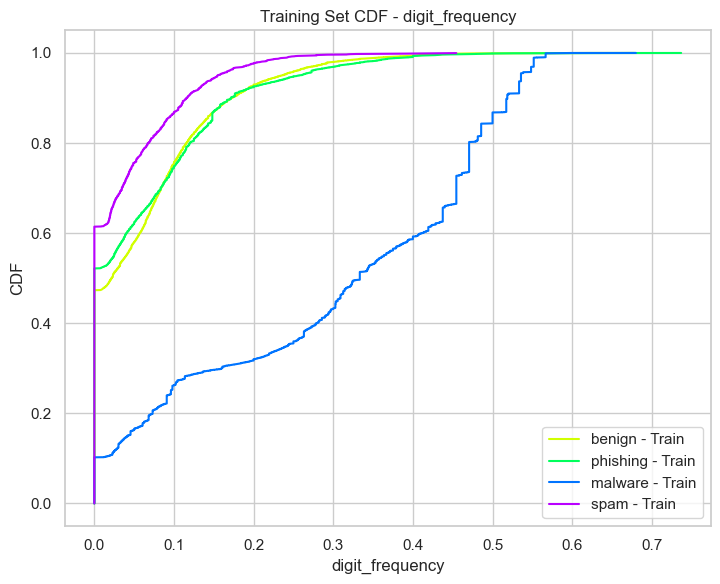

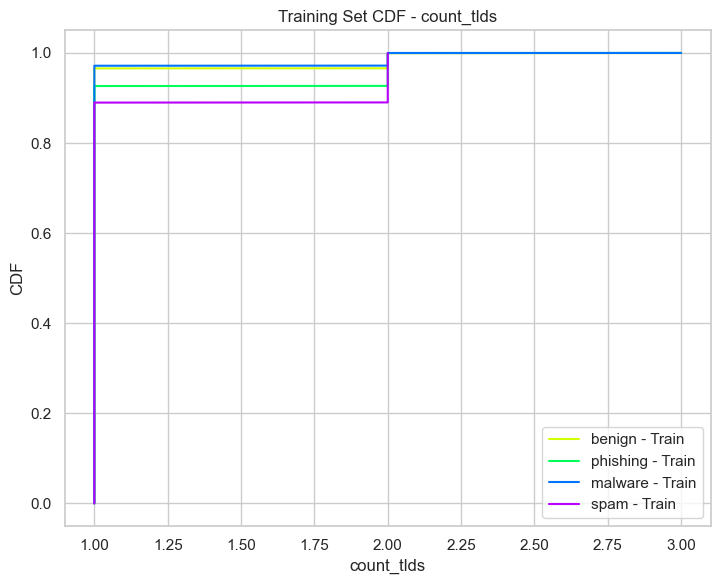

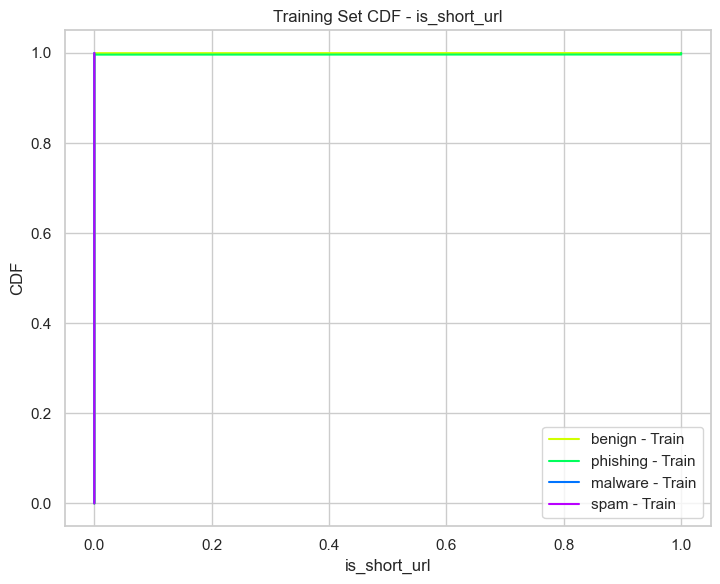

In [64]:
# Apply feature calculations to both datasets
plot_cdf_for_classes(url_df_features, features, 'label')



In [61]:
# Filters the DataFrame to include only numeric columns by using select_dtypes(include=[np.number]).
# Calculates the correlation matrix for these numeric features using the .corr() method.
# Uses sns.heatmap from the Seaborn library to plot the correlation matrix. 
# The heatmap is annotated with correlation coefficients,
# uses a 'coolwarm' color map for visualization, and includes format adjustments for clarity.

def plot_feature_correlation(df, title='Feature Correlation Heatmap'):
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()
        
        
# # Functionality:
# # Isolates numeric columns in the DataFrame similar to plot_feature_correlation.
# # Computes the absolute correlation matrix for these numeric features.
# # Focuses on the upper triangle of the correlation matrix to avoid redundant pairings.
# # Identifies features with correlations exceeding the specified threshold.
def identify_high_correlation(df, threshold=0.8):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    high_corr_pairs = [(feature, correlated_feature) for feature in upper.columns for correlated_feature in upper.columns if feature != correlated_feature and upper.at[feature, correlated_feature] > threshold]
    return high_corr_pairs

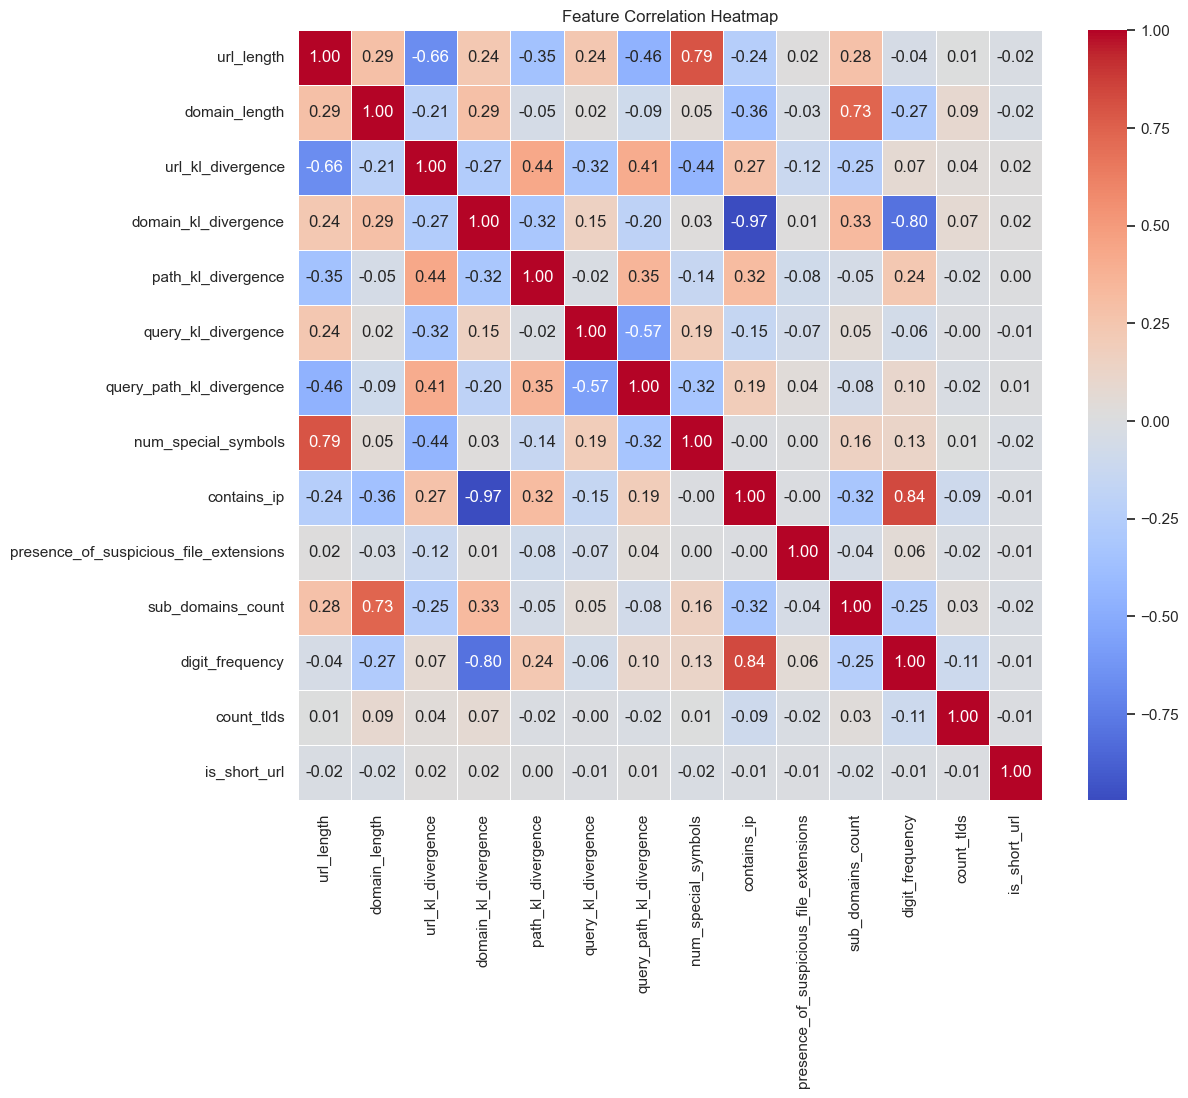

Highly Correlated Feature Pairs:
('domain_kl_divergence', 'contains_ip')
('contains_ip', 'digit_frequency')


In [62]:
plot_feature_correlation(url_df_features, title='Feature Correlation Heatmap')
high_corr_pairs = identify_high_correlation(url_df_features, 0.8)
print("Highly Correlated Feature Pairs:")
for pair in high_corr_pairs:
    print(pair)


